#Before your start with this Tutorial

**Tutorial Intention:** Providing an example of iteration and related step on a modeling phase for you to:

*   Experience the data science lifecycle using Vectice
*   See how simple it is to connect your notebook to Vectice
*   Learn how to structure and log your work using Vectice

**Resources needed:**
*   Forecast Unit Sales Tutorial Project: You can find it as part of your personal workspace named after your name
*   Vectice Webapp Documentation: 
*   Vectice API documentation: 



#PIP Install Packages

In [ ]:
!pip install -q python-dotenv gql Deprecated requests_toolbelt
!pip install --index-url https://test.pypi.org/simple/ vectice==22.4.9.0b4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.0 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.15 which is incompatible.
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 4.9 MB/s 
  Attempting uninstall: vectice
    Found existing installation: vectice 22.4.7.1
    Uninstalling vectice-22.4.7.1:
      Successfully uninstalled vectice-22.4.7.1


In [ ]:
!pip install --q squarify
!pip install --q s3fs
!pip install --upgrade boto3
!pip install --q plotly

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
boto3 1.26.15 requires botocore<1.30.0,>=1.29.15, but you have botocore 1.27.59 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached botocore-1.29.15-py3-none-any.whl (9.9 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.59
    Uninstalling botocore-1.27.59:
      Successfully uninstalled botocore-1.27.59
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.0 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.15 which is incompatible

#Import libraries

In [ ]:
# importing libraries
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # essential graphical output
import seaborn as sns  # enhanced graphical output
import numpy as np   # mathematical essentials

#import other libraries
import logging
import json
logging.basicConfig(level=logging.INFO)

In [ ]:
# import Vectice library
import vectice
from vectice import FileDataWrapper, DatasetSourceUsage 

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


#Connect to Vectice, Project and Phase

In [ ]:
#Connect to vectice Using the API
retail_ws = vectice.connect(config=r"API_token.json")

In [ ]:
#Connect to the project
retail_project = retail_ws.project(project="Tutorial Project: Forecast in store unit sales")

In [ ]:
# Get the phase for Data Understanding 
DU = retail_project.phase("Data Understanding")

In [ ]:
# Get the currently active iteration
iter = DU.iteration

#Collect Initial Data

In [ ]:
# Get the Collect Initial Data step
step = iter.step("Collect Initial Data")

In [ ]:
#read datasets
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv", parse_dates=['date'])
transactions = pd.read_csv("transactions.csv", parse_dates=['date'])
df = pd.read_csv("train_trimmed.csv")

In [ ]:
#Wrap datasets to export metadata to Vectice 
items_file_wrapped = FileDataWrapper(path="items.csv", name="Items origin")
holiday_file_wrapped = FileDataWrapper(path="holidays_events.csv", name="Holiday origin")
stores_file_wrapped = FileDataWrapper(path="stores.csv", name="Stores origin")
oil_file_wrapped = FileDataWrapper(path="oil.csv", name="Oil origin")
transactions_file_wrapped = FileDataWrapper(path="transactions.csv", name="Transactions origin")
df_file_wrapped = FileDataWrapper(path="train_trimmed.csv", name="Training origin")

In [ ]:
#push dataset metadata to Vectice webapp for versioning purposes
retail_project.origin_dataset = items_file_wrapped
retail_project.origin_dataset = holiday_file_wrapped
retail_project.origin_dataset = oil_file_wrapped
retail_project.origin_dataset = transactions_file_wrapped
retail_project.origin_dataset = df_file_wrapped

In [ ]:
#Close step, mark it as completed in the webapp and publish message
step.close(message="We selected all the dataset available")

#Describe data

In [ ]:
# Get the Describe Data step
step = iter.step("Describe Data")

In [ ]:
# formatting and printing the dimensions of the dataset (ROWS, COLUMNS)
print(f"""
Size of Original Dataset
                  All | Items | holiday | stores |  oil  | transactions
Observations:  {df.shape[0]}|  {items.shape[0]} |   {holiday_events.shape[0]}   |   {stores.shape[0]}   |  {oil.shape[0]} | {transactions.shape[0]} 
Features:          {df.shape[1]}  |    {items.shape[1]}  |    {holiday_events.shape[1]}    |   {stores.shape[1]}    |    {oil.shape[1]}  | {transactions.shape[1]}  
""")




Size of Original Dataset
                  All | Items | holiday | stores |  oil  | transactions
Observations:  1500930|  4100 |   350   |   54   |  1218 | 83488 
Features:          6  |    4  |    6    |   5    |    2  | 3  



In [ ]:
#provide info about the main dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21855606 entries, 0 to 21855605
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    float64
 3   item_nbr     float64
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 1000.5+ MB


In [ ]:
# to handle NaN’s
df.fillna(0) 
#pd.DatetimeIndex(df['date']).year # to get the year from the date.

KeyboardInterrupt: ignored

In [ ]:
#provide info about the item dataset
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [ ]:
#provide info about the stores dataset
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
#provide info about the holiday_events dataset
holiday_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [ ]:
#perform date formating
holiday_events['date'] = pd.to_datetime(holiday_events['date'], format="%Y-%m-%d")

In [ ]:
#provide a preview of the main dataset
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,5446657,2013-05-11,37.0,823245.0,12.0,NaN
1,87318640,2016-08-07,28.0,949629.0,5.0,False
2,36620449,2014-12-04,26.0,1010755.0,1.0,False
3,69984126,2016-02-08,21.0,177395.0,5.0,False
4,86521816,2016-07-30,32.0,1958252.0,1.0,False


In [ ]:
#Close step, mark it as completed in the webapp and publish message
step.close(message="NaN have been replaced by 0 and date have been set to a similar format. However, additional cleaning need to be performed")

#Explore Data

In [ ]:
# Get the Explore Data step
step = iter.step("Explore data")

In [ ]:
#describe statistically the main dataset
df.describe()

,id,store_nbr,item_nbr,unit_sales
count,2.185561e+07,2.185560e+07,2.185560e+07,2.185560e+07
mean,6.275779e+07,2.746420e+01,9.728300e+05,8.551748e+00
std,3.623243e+07,1.632964e+01,5.205178e+05,2.165260e+01
min,1.000000e+01,1.000000e+00,9.699500e+04,-3.600000e+03
25%,3.137969e+07,1.200000e+01,5.227210e+05,2.000000e+00
50%,6.275366e+07,2.800000e+01,9.594370e+05,4.000000e+00
75%,9.414271e+07,4.300000e+01,1.354380e+06,9.000000e+00
max,1.254970e+08,5.400000e+01,2.127114e+06,1.714600e+04


###Stores Visualizations

NameError: ignored

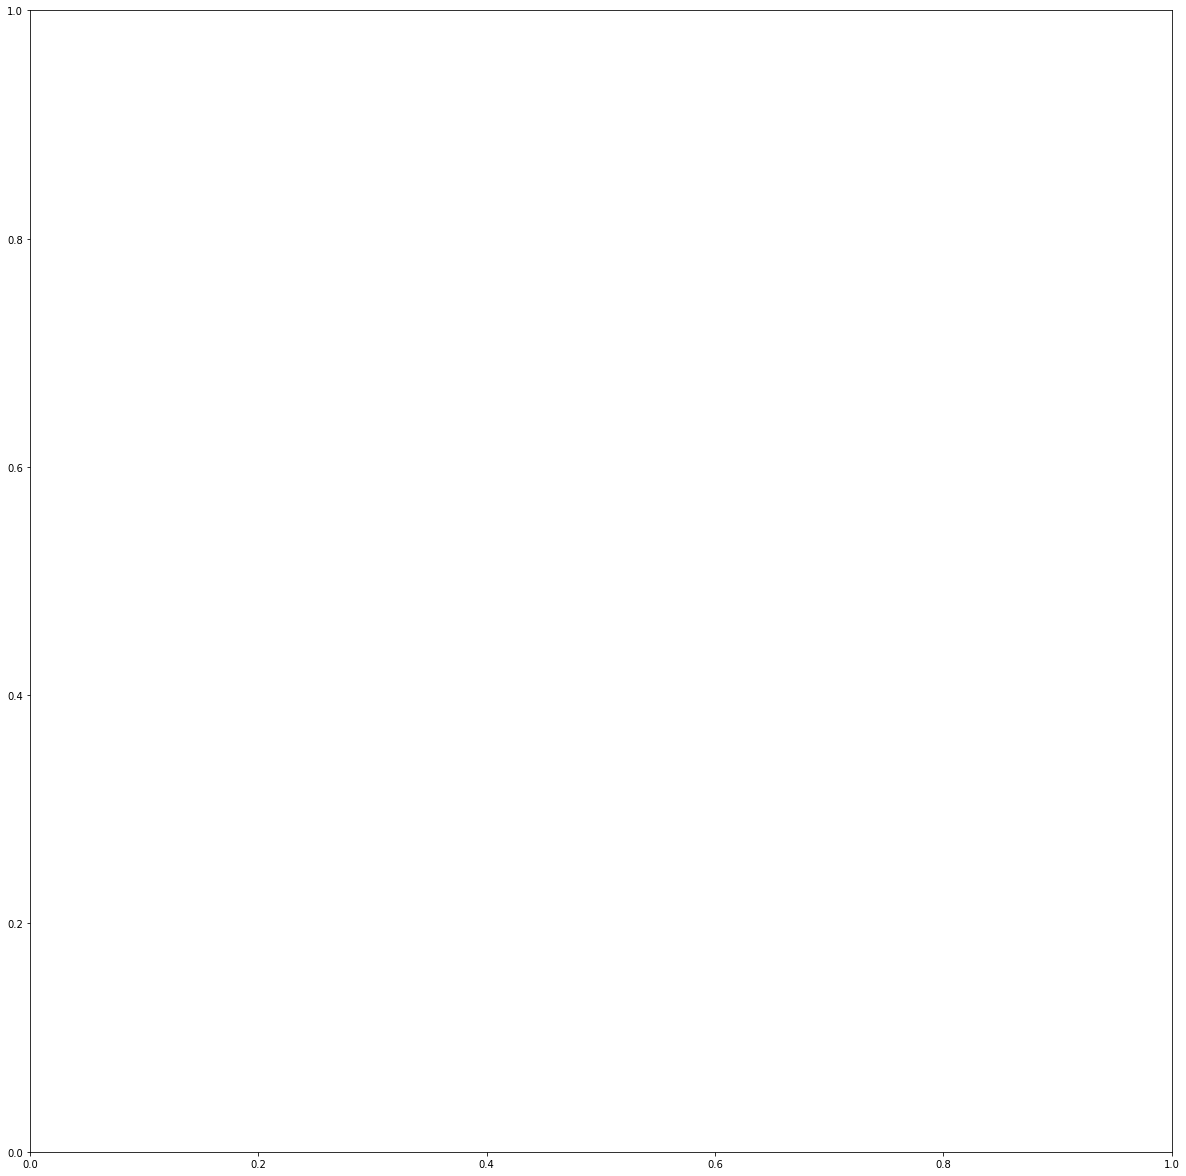

In [ ]:
#Treemap of store counts across different cities
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.city.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko['city'].values,label=marrimeko.index,
              color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different cities", fontsize=18)
plt.show();
fig.savefig('Store1.png', dpi=300)

In [ ]:
#Treemap of store counts across different States
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.state.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko['state'].values,label=marrimeko.index,
              color=sns.color_palette('viridis_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different States", fontsize=18)
plt.show()
fig.savefig('Store2.png', dpi=300)

####Inspecting the allocation of clusters to store numbers - Visualizations

In [ ]:
#Store numbers and the clusters they are assigned to
# Unhide to see the sorted zip order
neworder = [23, 24, 26, 36, 41, 15, 29, 31, 32, 34, 39, 
            53, 4, 37, 40, 43, 8, 10, 19, 20, 33, 38, 13, 
            21, 2, 6, 7, 3, 22, 25, 27, 28, 30, 35, 42, 44, 
            48, 51, 16, 0, 1, 5, 52, 45, 46, 47, 49, 9, 11, 12, 14, 18, 17, 50]

# Finally plot the seaborn heatmap
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot("store_nbr","cluster", "store_nbr")
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to')
plt.savefig('Store3.png', dpi=300)

In [ ]:
#Stacked Barplot of Store types and their cluster distribution
plt.style.use('dark_background')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()
plt.savefig('Store4.png', dpi=300);

###Holidays Visualization

In [ ]:
#Stacked Barplot of locale name against event type
holiday_local_type = holiday_events.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()
plt.savefig('holiday.png')

###Transactions Visualization

In [ ]:
#Distribution of transactions per day from 2013 till 2017
plt.style.use('seaborn-white')
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.axvline(x='2015-12-23',color='red',alpha=0.3)
plt.axvline(x='2016-12-23',color='red',alpha=0.3)
plt.axvline(x='2014-12-23',color='red',alpha=0.3)
plt.axvline(x='2013-12-23',color='red',alpha=0.3)
plt.axvline(x='2013-05-12',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2015-05-10',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2016-05-08',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2014-05-11',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2017-05-14',color='green',alpha=0.2, linestyle= '--')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()
plt.savefig('transaction1317.png')

In [ ]:
#transactions per day
plt.style.use('seaborn-deep')
plt.figure(figsize=(13,11))
plt.plot(train.date.values, train.unit_sales)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.savefig('Transactionspday.png')


###Items Visualizations

In [ ]:
#Counts of items per family category
x, y = (list(x) for x in zip(*sorted(zip(items.family.value_counts().index, 
                                         items.family.value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    y=items.family.value_counts().values,
    x=items.family.value_counts().index,
    marker=dict(
        color=items.family.value_counts().values,
        colorscale = 'Portland',
        reversescale = False
    ),
    orientation='v',
)

layout = dict(
    title='Counts of items per family category',
     width = 800, height = 800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')
plt.savefig('Item1.png')

In [ ]:
#Number of items attributed to a particular item class
x, y = (list(x) for x in zip(*sorted(zip(items['class'].value_counts().index, 
                                         items['class'].value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    x=items['class'].value_counts().index,
    y=items['class'].value_counts().values,
    marker=dict(
        color=items['class'].value_counts().values,
        colorscale = 'Jet',
        reversescale = True
    ),
    orientation='v',
)

layout = dict(
    title='Number of items attributed to a particular item class',
     width = 800, height = 1400,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')
plt.savefig('Item2.png')

In [ ]:
#Stacked Barplot of locale name against event type
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.savefig('Item3.png')

In [ ]:
#Close step, mark it as completed in the webapp and publish message
step.close(message="I generated a total of 10 graphs. Some side reseach also gave sense to some data incoherence that could be observed. For example the 2016 hearthquake")

#Verify Data Quality

In [ ]:
# Get the Verify Data Quality step
step = iter.step("Verify Data Quality")

In [ ]:
#Close step, mark it as completed in the webapp and publish message
step.close(message="The information comprise in this dataset is accurate and comprehensive. As the information aligns with other trusted resources, the dataset was considered as reliable and also relevant to the business problem we are trying to solve. However, this data can not be used for real time reporting as the data does not update itself. ")